# TEST - Intensity Probability

In [3]:
import imageio.v2
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare
import scipy.special as sp
import scipy.stats as st 
# import scipy.integrate as integrate
# from scipy.integrate import dblquad
# import multiprocessing
import statistics
from scipy.signal import convolve2d
from scipy.ndimage import zoom

## Functions for intensity distribution

In [4]:
# INPUT: 3D intensity matrix with r, g, b, a values
# OUTPUT : 2D intensity matrix

def convert_3d_to_2d(matrix):
    if len(matrix.shape) == 2:
        return matrix
    ver, hor, _ = matrix.shape
    Im = np.zeros((ver, hor))
    for x in range(ver):
         for y in range(hor):
            r, g, b = matrix[x, y, 0], matrix[x, y, 1], matrix[x, y, 2]
            Im[x, y] = r
    return Im

In [5]:
# INPUT: TIFF from the camera
# OUTPUT: Display the speckle image

def displaySpeckle(path, Name, cmap='viridis', clim=None, save_as=None):
    """
    Display the intensity matrix with optional color map, color limits, and save option.
    
    Parameters:
        path: path
        Name.
        cmap (str): The color map to use for display.
        clim (tuple): Color limits for the plot (optional).
        save_as (str): File name to save the plot (optional).
    """
    # Display the image using matplotlib
    I = plt.imread(path)
    I = convert_3d_to_2d(I)
    plt.imshow(I, cmap=cmap)
    plt.title(Name)
    plt.colorbar()

    # Set color limits if provided
    if clim:
        plt.clim(clim)

    # Save the figure if a filename is provided
    if save_as:
        plt.savefig(save_as)
    
    # Show the plot
    plt.show()

    # Optionally print some statistics
    print(f"Shape of the intensity matrix: {I.shape}")
    print(f"Max value: {I.max()}")
    print(f"Min value: {I.min()}")

In [6]:
# INPUT: size of the desired image
# OUTPUT: the simulated speckle with the intensity scaled to 8-bit digital intensity [0,255]
# NOTE: the first line of the code controls the correlation length

def simulated(s):
    random_matrix = np.random.rand(2**6, 2**6) # controls the correlation length

    # Compute the complex exponential
    complex_matrix = np.exp(-2 * np.pi * 1j * random_matrix)

    # Compute the 2D FFT, zero-padded to 2048x2048
    fft_matrix = np.fft.fft2(complex_matrix, s)

    # Shift the zero-frequency component to the center
    shifted_fft_matrix = np.fft.fftshift(fft_matrix)

    # Compute the magnitude and square it
    mag = np.abs(shifted_fft_matrix) ** 2
    mag = (mag/mag.max())*255
    return mag

In [7]:
# INPUT: speckle intensity matrix (2D or 3D), background intensity matrix (2D or 3D)
# OUTPUT: the 2D intensity matrix with background reduction

def backgroundReduction(speckle, bg):
    try:
        # Check if the speckle is a 3D matrix
        if len(speckle.shape) == 3:
            speckle = convert_3d_to_2d(speckle)
        elif len(speckle.shape) != 2:
            raise ValueError("The speckle matrix must be 2D or 3D.")
            
        if len(bg.shape) == 3:
            bg = convert_3d_to_2d(bg)
        elif len(bg.shape) != 2:
            raise ValueError("The background matrix must be 2D or 3D.")
        
        # Continue with the background reduction process
        reduced_speckle = speckle - bg
        
        return reduced_speckle
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [8]:
# INPUT: speckle intensity matrix (2D or 3D)
# OUTPUT:  increase the resolution of the speckle intensity matrix by a factor 2, using bicubic interpolation method.
def bicubicInterpolation(Im):
    try:
        # Check if the speckle is a 3D matrix
        if len(Im.shape) == 3:
            speckle = convert_3d_to_2d(speckle)
        elif len(Im.shape) != 2:
            raise ValueError("The speckle matrix must be 2D or 3D.")
        
        img = Image.fromarray((Im).astype(np.uint8))
        width, height = img.size
        new_size = (width * 2, height * 2)

        # Resize the image using bicubic interpolation
        img_resized = img.resize(new_size, Image.BICUBIC)
        img_resized.save('resized_image.tif')
        img_resized = np.array(img_resized)
        return img_resized
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [9]:
# INPUT:  speckle intensity matrix (2D or 3D)
# OUTPUT: decrease the resolution of the speckle intensity matrix by a factor 2, with 2x2 binning

def binningByFactorOfTwo(Im):
    try:
        # Check if the speckle is a 3D matrix
        if len(Im.shape) == 3:
            Im = convert_3d_to_2d(speckle)
        elif len(Im.shape) != 2:
            raise ValueError("The speckle matrix must be 2D or 3D.")
        kernel = np.ones((2, 2)) / 4

        # Convolve the intensity matrix with the averaging kernel
        convolved_matrix = convolve2d(Im, kernel, mode='valid')

        # Downsample by taking every second element in both dimensions
        binned_matrix = convolved_matrix[::2, ::2]
        plt.imshow(binned_matrix, cmap='grey')
        Im = binned_matrix
        return Im
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [10]:
# INPUT: intensity matrix (2D or 3D), horizontal start (of a dark region), vertical start, horizontal end, vertical end (in pixels)
# OUTPUT: deduct the pixels that have intensities lower than the the average intensity in a dark region,  this directly returns an 1d array that can be used to plotting
# NOTE: select a region that is though to be dark, then the code find the average over that region. The pixels have intensity lower than that average
# in the entire matrix will be discarded. Aim to work for an image with large dark region, e.g. a Gaussian intensity image
def averageReduction(I, horStart, verStart, horEnd, verEnd):
    try:
        # Check if the speckle is a 3D matrix
        if len(I.shape) == 3:
            I = convert_3d_to_2d(I)
        elif len(I.shape) != 2:
            raise ValueError("The speckle matrix must be 2D or 3D.")
            
        horStart= 0 
        verStart = 0
        horEnd= 100
        verEnd = 100
        ImD = np.zeros((horUp - horStart, verUp - verStart))
        # print(Im)
        for x in range(verStart, verUp):
              for y in range(horStart, horUp):
                    ImD[x][y] = I[x][y]

        threshold = ImD.max()
        print('threshold is', threshold)
        
        cnt = 0
        cnMax = 0
        ver, hor = Im.shape
        for x in range(0, ver):
              for y in range(0, hor):
                    if I[x][y] <= threshold:
                        cnt += 1
                    # if Im[x][y] == 255:
                    #     cnMax += 1
        print('amount of pixels that have an intensity lower than threshold is', cnt)
        
        inp = Im.ravel()

        #Ordering and Cropping
        inp = np.sort(inp)
        inp = inp[cnt+1: inp.size]
        return inp
    
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [11]:
# INPUT: intensity matrix (2D or 3D), horizontal start (of selected region), vertical start, horizontal end, vertical end (in pixels)
# OUTPUT: the intensity matrix with the selected size
def pixelSelection(I, hor_start, ver_start, ho_end, ver_end):
    try:
        # Check if the speckle is a 3D matrix
        if len(I.shape) == 3:
            I = convert_3d_to_2d(I)
        elif len(I.shape) != 2:
            raise ValueError("The speckle matrix must be 2D or 3D.")
            
        ver_length = ver_end - ver_start
        hor_length = hor_end - hor_start
        selected = np.zeros((ver_length, hor_length))
        for y in range(0, ver_length):
            for x in range(0, hor_length):
                selected[y][x] = Im[ver_start+y-1][hor_start+x-1]
            
        return selected

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [12]:
# INPUT： 1d array of intensity
# #OUTPUT: Plot the probability distribution in 1) regular scale 2) logarithmic scale with the theory 
def plotProbabilityDistribution(inp):
    try:
        # Check if the input is 1D
        if len(inp.shape) != 1:
            raise ValueError("The array needs to be 1D")
        
        # Compute necessary statistics
        avg = inp.mean()
        I_0 = inp.max() / avg
        sigma = np.std(inp)
        # print("Average Intensity:", avg)
        # print("Input Array:", inp)

        # Normalize input by average
        inpu = inp / avg
        # print("Max of Normalized Input:", inpu.max())
        # print("Min of Normalized Input:", inpu.min())

        # Histogram of the normalized input
        hist, bin_edges = np.histogram(inpu, bins=70, density=True)

        # Calculate the bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot the histogram (relative probability)
        plt.plot(bin_centers, hist, label='Relative Probability')
        plt.xlabel('Intensity (I/⟨I⟩)')
        plt.ylabel('Relative Probability P(I)')
        plt.title('Relative Probability of Intensity Data')
        plt.legend()
        plt.savefig('Prob.png')
        plt.show()

        # Create an array of intensities for the theoretical distribution
        I_Im = np.linspace(0, inp.max(), 1000)
        P = np.exp(-I_Im / avg)
        I_Im = I_Im / avg

        # Plot the theoretical distribution with logarithmic scale
        plt.figure(figsize=(10, 6))
        plt.plot(I_Im, P, label='$P = e^{-I/\\langle I \\rangle}/\\langle I \\rangle$', color='blue')

        # Actual data plot (histogram)
        plt.plot(bin_centers, hist, label='Actual Data', color='orange')

        # Set the y-axis to a logarithmic scale
        plt.yscale('log')
        plt.xlabel('$I/\\langle I \\rangle$')
        plt.ylabel('Probability $P$')
        plt.title('Logarithmic Plot of the Probability Distribution')

        # Legend and grid
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Calculate the theoretical frequency for the bin centers
        expected_freq = np.interp(bin_centers, I_Im, P)

        # Normalize the theoretical frequency to match the total histogram count
        expected_freq = expected_freq * np.sum(hist) / np.sum(expected_freq)

        # Chi-square test
        chi2, pv = chisquare(hist, f_exp=expected_freq)

        # Show and save the final plot
        plt.savefig('resultsD.png')
        plt.show()

        # Compute contrast and signal-to-noise ratio
        C = sigma / avg
        R = avg / sigma
        print("Contrast is", C)
        print("Signal-to-noise ratio is", R)
        print("Chi-squared value is", chi2, "and p-value is", pv)
        
    except ValueError as ve:
        print(f"ValueError: {ve}")

## Functions for ACF

In [13]:
# INPUT: x-coord array, y-coord array, wavelength, axial distance, x-waist, y-waist
# OUTPUT: the intensity function of Gaussian beam incorporated with the neccessary change for doing a FFT
def I_acf(g, h, L, z, wx, wy):
    hor = 1280
    ver = 1024
    return I0*np.exp(-2*(((g*L*z-hor/2)**2)/(wx)**2+(((h*L*z-ver/2)**2)/(wy)**2)))

In [14]:
# INPUT: x-coord array, y-coord array, x-waist, y-waist
# OUTPUT: the intensity function of Gaussian beam
def I_normal(g, h, wx, wy):
    hor = 1280
    ver = 1024
    return I0*np.exp(-2*(((g-hor/2)**2)/wx**2+(((h-ver/2)**2)/wy**2)))

In [15]:
# INPUT: x values (account for number of y values), y values (actual data)
# OUTPUT: difference in 90 percent confidence range in y values
def confidence90(x_values, y_values):
    pdf = y_values/  np.sum(y_values)

    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(pdf)

    # Find the x-values corresponding to the 2.5th percentile and the 97.5th percentile
    length = x_values[np.searchsorted(cdf, 0.95)] - x_values[np.searchsorted(cdf, 0.05)]
    return length

In [16]:
# INPUT: data
# OUTPUT: Full width half max of the data
def fwhm(y):
    x = np.linspace(0, len(y)-1, len(y))
    half_max = (np.max(y)+np.min(y)) / 2.0
    # nintyfive = (np.max(y)+np.min(y)) * 0.45
    indices_above_threshold = np.where(y >= half_max)[0]

    if len(indices_above_threshold) < 2:
        return 0  # Not enough points above threshold

    left_index = indices_above_threshold[0]
    right_index = indices_above_threshold[-1]

    fwhm_value = x[right_index] - x[left_index]
    return fwhm_value

In [17]:
# INPUT: speckle intensity matrix (2D or 3D)
# OUTPUT: return the 2D ACF of the speckle
def speckleImgProcessing(mag):
    # Helper function to convert 3D matrix to 2D by extracting the red channel
    if len(mag.shape) == 3:
            mag = convert_to_2d(mag)
    elif mag.ndim != 2:
        raise ValueError("Input matrix must be either 2D or 3D.")

    # Perform FFT operations
    T2 = np.fft.fft2(mag)
    T2 = np.fft.fftshift(T2)
    T3 = np.power(np.abs(T2), 2)
    T4 = np.fft.ifft2(T3)
    T4 = np.fft.fftshift(T4)
    T4 = np.abs(T4)

    return T4

In [18]:
# INPUT: Measured 2D ACF matrix
# OUTPUT: display full ACF over x and y axis, and zoomed-in ACF (40 pixels around the center) over x and y axis
def displayMeasuredCorreL(T4):
    # Get the shape of the input data
    x = np.arange(T4.shape[1])
    y = np.arange(T4.shape[0])
    
    ver = T4.shape[0]
    hor = T4.shape[1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))

    # Top row: Display the full 2D array T4
    im = axs[0, 0].imshow(T4, cmap='viridis', origin='lower', aspect='auto')
    axs[0, 0].set_title('Full 2D ACF')
    axs[0, 0].set_xlabel('Delta x (px)')
    axs[0, 0].set_ylabel('Delta y (px)')
#    axs[0, 0].legend()
    fig.colorbar(im, ax=axs[0, 0])
    axs[0, 1].axis('off')  # Empty subplot to maintain layout symmetry
    
    T4=T4 / T4.max()
    verSlice = T4[:, int(hor / 2)]
    horSlice = T4[int(ver / 2), :]
    
    
    
    # Top left: Full scale plot of ACF over delta x
    axs[1, 0].plot(x, horSlice, label='measured')
    axs[1, 0].set_title('ACF over delta x, full scale')
    axs[1, 0].set_xlabel('Delta x (px)')
    axs[1, 0].set_ylabel('ACF')
    axs[1, 0].legend()
    print('Horizontal FWHM of full wave pattern is', fwhm(horSlice))

    # Top right: Full scale plot of ACF over delta y
    axs[1, 1].plot(y, verSlice, label='measured')
    axs[1, 1].set_title('ACF over delta y, full scale')
    axs[1, 1].set_xlabel('Delta y (px)')
    axs[1, 1].set_ylabel('ACF')
    axs[1, 1].legend()
    print('Vertical FWHM of full wave pattern is', fwhm(horSlice))

    # Bottom left: Zoomed-in plot of ACF over delta x
    axs[2, 0].plot(x, horSlice, label='measured')
    axs[2, 0].set_xlim(int(hor/2)-20, int(hor/2)+20)  # Adjust to zoom in
    # axs[2, 0].set_ylim(0.6, 1.0)  # Adjust to zoom in (example limits)
    axs[2, 0].set_title('ACF over delta x, zoomed in')
    axs[2, 0].set_xlabel('Delta x (px)')
    axs[2, 0].set_ylabel('ACF')
    axs[2, 0].legend()
    print('Horizontal FWHM of cropped wave pattern is', fwhm(horSlice[int(hor/2)-20: int(hor/2)+20]))
    

    # Bottom right: Zoomed-in plot of ACF over delta y
    axs[2, 1].plot(y, verSlice, label='measured')
    axs[2, 1].set_xlim(int(ver/2)-20, int(ver/2)+20)  # Adjust to zoom in
    # axs[2, 1].set_ylim(0.6, 1.0)  # Adjust to zoom in (example limits)
    axs[2, 1].set_title('ACF over delta y, zoomed in')
    axs[2, 1].set_xlabel('Delta y (px)')
    axs[2, 1].set_ylabel('ACF')
    axs[2, 1].legend()
    print('Vertical FWHM of cropped wave pattern is', fwhm(verSlice[int(ver/2)-20: int(ver/2)+20]))

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

In [19]:
# INPUT: wavelength of the lightbeam, distance away from the lens, waists of the Gaussian
#           this is based on setup where we have a lens before (or after) the diffuser, and we measure at the focal length
# OUTPUT: theoretical 2D ACF
def TheoreticalACF(L, z, wx, wy):
    hor = 1280
    ver =  1024
    gr = int(hor)
    hr = int(ver)
    gr_range = np.linspace(0, gr-1, hor)
    hr_range = np.linspace(0, hr-1, ver)
    alpha_range = np.linspace(0, hor-1, hor)
    beta_range = np.linspace(0, ver-1, ver)
    g,h = np.meshgrid(gr_range, hr_range)
    # Compute the intensity grid
    intensity_grid = I_acf(g, h, L, z, wx, wy)
    # Shift the zero-frequency component to the center of the spectrum
    fft_intensity = np.fft.fftshift(np.fft.fft2(intensity_grid))
    # Compute the normalized result
    C2I_values = avg**2 * (1 + ((L*z)**2)*np.abs(fft_intensity / np.sum(intensity_grid))**2)
    
    return C2I_values

In [20]:
# INPUT: Theoretical 2D FFT
# OUTPUT: display full ACF over x and y axis, and zoomed-in ACF (40 pixels around the center) over x and y axis
def displayTheoreticalCorreL(Theo):
        # Get the shape of the input data
    x = np.arange(Theo.shape[1])
    y = np.arange(Theo.shape[0])
    
    ver = Theo.shape[0]
    hor = Theo.shape[1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))

    # Top row: Display the full 2D array T4
    im = axs[0, 0].imshow(Theo, cmap='viridis', origin='lower', aspect='auto')
    axs[0, 0].set_title('Full 2D Theoretical ACF')
    axs[0, 0].set_xlabel('Delta x (px)')
    axs[0, 0].set_ylabel('Delta y (px)')
#    axs[0, 0].legend()
    fig.colorbar(im, ax=axs[0, 0])
    axs[0, 1].axis('off')  # Empty subplot to maintain layout symmetry
    
        
    Theo = Theo/ Theo.max()    
    
    verSlice = Theo[:, int(hor / 2)]
    horSlice = Theo[int(ver / 2), :]
    
    
    # Top left: Full scale plot of ACF over delta x
    axs[1, 0].plot(x, horSlice, label='theoretical', color='orange')
    axs[1, 0].set_title('ACF over delta x, full scale')
    axs[1, 0].set_xlabel('Delta x (px)')
    axs[1, 0].set_ylabel('ACF')
    axs[1, 0].legend()
    print('Horizontal FWHM of full wave pattern is', fwhm(horSlice))

    # Top right: Full scale plot of ACF over delta y
    axs[1, 1].plot(y, verSlice, label='theoretical', color='orange')
    axs[1, 1].set_title('ACF over delta y, full scale')
    axs[1, 1].set_xlabel('Delta y (px)')
    axs[1, 1].set_ylabel('ACF')
    axs[1, 1].legend()
    print('Vertical FWHM of full wave pattern is', fwhm(horSlice))

    # Bottom left: Zoomed-in plot of ACF over delta x
    axs[2, 0].plot(x, horSlice, label='theoretical', color='orange')
    axs[2, 0].set_xlim(int(hor/2)-20, int(hor/2)+20)  # Adjust to zoom in
    # axs[2, 0].set_ylim(0.6, 1.0)  # Adjust to zoom in (example limits)
    axs[2, 0].set_title('ACF over delta x, zoomed in')
    axs[2, 0].set_xlabel('Delta x (px)')
    axs[2, 0].set_ylabel('ACF')
    axs[2, 0].legend()
    print('Horizontal FWHM of cropped wave pattern is', fwhm(horSlice[int(hor/2)-20: int(hor/2)+20]))
    

    # Bottom right: Zoomed-in plot of ACF over delta y
    axs[2, 1].plot(y, verSlice, label='theoretical', color='orange')
    axs[2, 1].set_xlim(int(ver/2)-20, int(ver/2)+20)  # Adjust to zoom in
    # axs[2, 1].set_ylim(0.6, 1.0)  # Adjust to zoom in (example limits)
    axs[2, 1].set_title('ACF over delta y, zoomed in')
    axs[2, 1].set_xlabel('Delta y (px)')
    axs[2, 1].set_ylabel('ACF')
    axs[2, 1].legend()
    print('Vertical FWHM of cropped wave pattern is', fwhm(verSlice[int(ver/2)-20: int(ver/2)+20]))

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

In [21]:
# INPUT: Measure 2D FFT, theoretical 2D FFT
# OUTPUT: comparison in full ACF over x and y axis, and zoomed-in ACF (40 pixels around the center) over x and y axis
def displayComparison(T4, C2I):
    hor, ver = C2I_values.shape[1], C2I_values.shape[0]
    
    # Theoretical ACF (full scale, x-axis)
    T6 = C2I_values[int(ver / 2)]
    T6 = T6 / T6.max()

    # Measured ACF (full scale, x-axis)
    T7 = T4[int(ver / 2)]
    T7 = T7 / T7.max()

    # Zoomed in range
    zoom_range = slice(int(hor / 2) - 20, int(hor / 2) + 20)
    
    # Zoomed-in ACF (x-axis)
    T8 = T6[zoom_range]
    T9 = T7[zoom_range]

    # Calculating FWHM for theoretical and measured ACFs
    Tfwhm = fwhm(T8)
    Mfwhm = fwhm(T9)

    # Percentage error in FWHM
    percentage_error_x = (np.abs(Tfwhm - Mfwhm) / Tfwhm) * 100

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Full scale plot (x-axis)
    axs[0, 0].plot(T6, label='Theoretical', color='orange')
    axs[0, 0].plot(T7, label='Measured', color='blue')
    axs[0, 0].set_title('ACF over delta x, full scale')
    axs[0, 0].set_xlabel('Delta x (px)')
    axs[0, 0].set_ylabel('ACF')
    axs[0, 0].legend()

    # Zoomed-in plot (x-axis)
    axs[0, 1].plot(T6, label='Theoretical', color='orange')
    axs[0, 1].plot(T7, label='Measured', color='blue')
    axs[0, 1].set_xlim(int(hor/2)-20, int(hor/2)+20)  
    axs[0, 1].set_title('ACF over delta x, zoomed in')
    axs[0, 1].set_xlabel('Delta x (px)')
    axs[0, 1].set_ylabel('ACF')
    axs[0, 1].legend()

    # Repeat the process for the y-axis
    T10 = C2I_values[:, int(hor / 2)]
    T10 = T10 / T10.max()
    
    T11 = T4[:, int(hor / 2)]
    T11 = T11 / T11.max()
    


    T12 = T10[int(ver/2)-20: int(ver/2)+20]
    T13 = T11[int(ver/2)-20: int(ver/2)+20]
    
    Tyfwhm = fwhm(T12)
    Myfwhm = fwhm(T13)
    
    percentage_error_Y = (np.abs(Tyfwhm - Myfwhm) / Tyfwhm) * 100
    
    # Full scale plot (y-axis)
    axs[1, 0].plot(T10, label='Theoretical', color='orange')
    axs[1, 0].plot(T11, label='Measured', color='blue')
    axs[1, 0].set_title('ACF over delta y, full scale')
    axs[1, 0].set_xlabel('Delta y (px)')
    axs[1, 0].set_ylabel('ACF')
    axs[1, 0].legend()
    
    # Zoomed-in plot (y-axis)
    axs[1, 1].plot(T10, label='Theoretical', color='orange')
    axs[1, 1].plot(T11, label='Measured', color='blue')
    axs[1, 1].set_xlim(int(ver/2)-20, int(ver/2)+20)  
    axs[1, 1].set_title('ACF over delta y, zoomed in')
    axs[1, 1].set_xlabel('Delta y (px)')
    axs[1, 1].set_ylabel('ACF')
    axs[1, 1].legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print results
    print("FWHM for theoretical x-axis:", Tfwhm)
    print("FWHM for measured x-axis:", Mfwhm)
    print("Percentage error for x-axis FWHM:", percentage_error, "%")
    print("FWHM for theoretical y-axis:", Tyfwhm)
    print("FWHM for measured y-axis:", Myfwhm)
    print("Percentage error for y-axis FWHM:", percentage_error, "%")


In [22]:
# INPUT: Measure 2D FFT, theoretical 2D FFT
# OUTPUT: comparison (with overlapping bottom line) in full ACF over x and y axis, and zoomed-in ACF (40 pixels around the center) over x and y axis
def displayComparisonWithSameAxis(Mea, Theo):
    hor, ver = C2I_values.shape[1], C2I_values.shape[0]
    
    # Theoretical ACF (full scale, x-axis)
    T6 = C2I_values[int(ver / 2)]
    T6 = T6 / T6.max()

    # Measured ACF (full scale, x-axis)
    T7 = T4[int(ver / 2)]
    T7 = T7 / T7.max()

    # Zoomed in range
    zoom_range_x = slice(int(hor / 2) - 20, int(hor / 2) + 20)
    
    # Zoomed-in ACF (x-axis)
    T8 = T6[zoom_range_x]
    T9 = T7[zoom_range_x]

    # Calculating FWHM for theoretical and measured ACFs
    Tfwhm_x = fwhm(T8)
    Mfwhm_x = fwhm(T9)

    # Percentage error in FWHM
    percentage_error_x = (np.abs(Tfwhm_x - Mfwhm_x) / Tfwhm_x) * 100

    # Repeat the process for the y-axis
    T10 = C2I_values[:, int(hor / 2)]
    T10 = T10 / T10.max()
    
    T11 = T4[:, int(hor / 2)]
    T11 = T11 / T11.max()

    # Zoomed-in ACF (y-axis)
    zoom_range_y = slice(int(ver / 2) - 20, int(ver / 2) + 20)
    T12 = T10[zoom_range_y]
    T13 = T11[zoom_range_y]
    
    Tyfwhm = fwhm(T12)
    Myfwhm = fwhm(T13)
    
    percentage_error_y = (np.abs(Tyfwhm - Myfwhm) / Tyfwhm) * 100
    
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Full scale plot (x-axis)
    ax1 = axs[0, 0]
    ax2 = ax1.twinx()
    ax1.plot(T6, label='Theoretical', color='orange')
    ax2.plot(T7, label='Measured', color='blue')
    ax1.set_title('ACF over delta x, full scale')
    ax1.set_xlabel('Delta x (px)')
    ax1.set_ylabel('Theoretical ACF')
    ax2.set_ylabel('Measured ACF')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Zoomed-in plot (x-axis)
    ax3 = axs[0, 1]
    ax4 = ax3.twinx()
    ax3.plot(T6, label='Theoretical', color='orange')
    ax4.plot(T7, label='Measured', color='blue')
    ax3.set_xlim(int(hor/2)-20, int(hor/2)+20)
    ax4.set_xlim(int(hor/2)-20, int(hor/2)+20)
    ax3.set_title('ACF over delta x, zoomed in')
    ax3.set_xlabel('Delta x (px)')
    ax3.set_ylabel('Theoretical ACF')
    ax4.set_ylabel('Measured ACF')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')

    # Full scale plot (y-axis)
    ax5 = axs[1, 0]
    ax6 = ax5.twinx()
    ax5.plot(T10, label='Theoretical', color='orange')
    ax6.plot(T11, label='Measured', color='blue')
    ax5.set_title('ACF over delta y, full scale')
    ax5.set_xlabel('Delta y (px)')
    ax5.set_ylabel('Theoretical ACF')
    ax6.set_ylabel('Measured ACF')
    ax5.legend(loc='upper left')
    ax6.legend(loc='upper right')
    
    # Zoomed-in plot (y-axis)
    ax7 = axs[1, 1]
    ax8 = ax7.twinx()
    ax7.plot(T10, label='Theoretical', color='orange')
    ax8.plot(T11, label='Measured', color='blue')
    ax7.set_xlim(int(ver/2)-20, int(ver/2)+20)
    ax8.set_xlim(int(ver/2)-20, int(ver/2)+20)
    ax7.set_title('ACF over delta y, zoomed in')
    ax7.set_xlabel('Delta y (px)')
    ax7.set_ylabel('Theoretical ACF')
    ax8.set_ylabel('Measured ACF')
    ax7.legend(loc='upper left')
    ax8.legend(loc='upper right')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print results
    print("FWHM for theoretical x-axis:", Tfwhm_x)
    print("FWHM for measured x-axis:", Mfwhm_x)
    print("Percentage error for x-axis FWHM:", percentage_error_x, "%")
    print("FWHM for theoretical y-axis:", Tyfwhm)
    print("FWHM for measured y-axis:", Myfwhm)
    print("Percentage error for y-axis FWHM:", percentage_error_y, "%")

    return Tfwhm_x, Mfwhm_x, Tyfwhm, Myfwhm

# Start

## 1. Light Pattern Source File

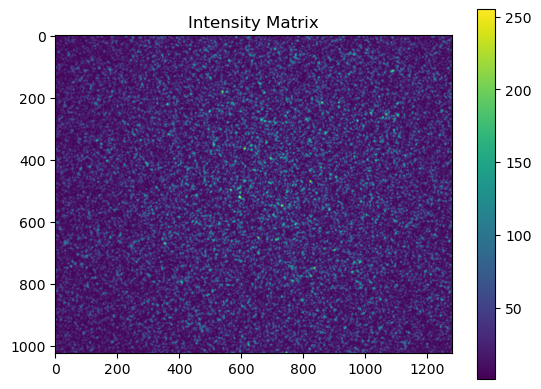

Shape of the intensity matrix: (1024, 1280)
Max value: 255.0
Min value: 1.0


In [24]:
path = '../NSERC2024/Nuevos2/807t1.tif'
I = plt.imread(path)

name =  'Intensity Matrix'
displaySpeckle(path, name, cmap='viridis', clim=None, save_as='imageD.png')

(600, 600)


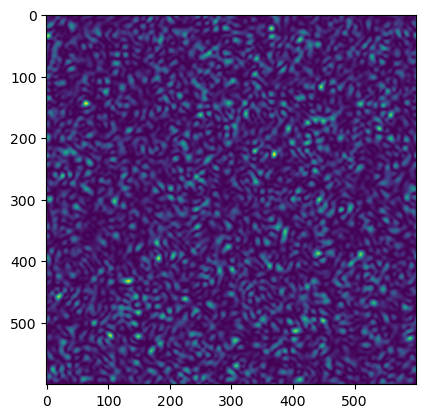

[[ 7.60424981 10.1071692  11.76628156 ...  0.59925101  2.25383373
   4.77772357]
 [11.98083887 14.30079926 15.41127955 ...  2.92352532  5.61413383
   8.86910077]
 [16.3656628  18.26460896 18.76067365 ...  6.41866219  9.76063197
  13.33320683]
 ...
 [ 2.46519319  4.88595904  7.31180838 ...  3.87409931  1.33938841
   1.01580076]
 [ 2.29548417  4.63522641  6.88198026 ...  1.33702321  0.15951669
   0.59718341]
 [ 4.12948593  6.58640107  8.62367613 ...  0.0594916   0.36281943
   1.85932547]]
(600, 600)


In [109]:
# Generate a 64x64 matrix of random numbers uniformly distributed between 0 and 1
s = (600, 600)   # size of the spekcle image
mag = simulated(s)
print(mag.shape)
plt.imshow(mag)
plt.show()
print(mag)
print(mag.shape)
inp = mag.ravel()

## 2a. Background Reduction

### Background Noise Source File

In [25]:
Bpath = '../NSERC2024/Nuevos2/816bg2.tif'
B = plt.imread(Bpath)

### Reduction

[[10. 20. 37. ... 16.  9.  2.]
 [12. 25. 42. ...  7.  4.  2.]
 [14. 22. 37. ...  3.  2.  2.]
 ...
 [29. 26. 22. ... 40. 50. 73.]
 [34. 24. 20. ... 49. 55. 72.]
 [31. 25. 17. ... 74. 76. 84.]]


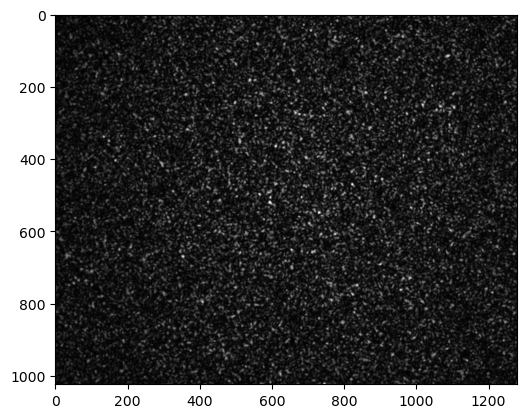

In [26]:
Im = backgroundReduction(I, B)
print(Im)
plt.imshow(Im, cmap='gray')
# plt.show()

[[ 5  7 10 ... 10 15 17]
 [ 5  7 10 ...  9 12 14]
 [ 6  7  8 ...  6  7  8]
 ...
 [ 1  1  2 ...  3  4  5]
 [ 2  2  2 ...  3  5  5]
 [ 2  2  2 ...  3  5  5]]
5242880
255
0


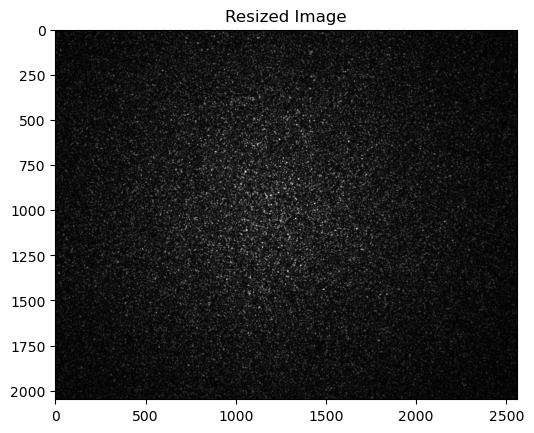

In [20]:
img_resized = bicubicInterpolation(Im)
print(img_resized)
print(img_resized.size)
print(img_resized.max())
print(img_resized.min())

# Display the resized image
# plt.imshow(IM)
plt.imshow(img_resized, cmap='gray')
plt.title('Resized Image')
plt.show()


In [10]:
Im = img_resized

## Binning

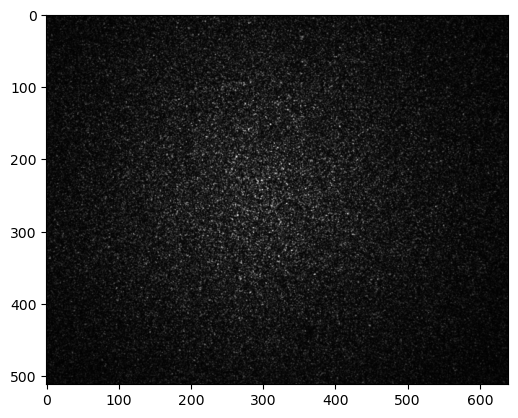

In [28]:
Im = binningByFactorOfTwo(Im)

### Smash!

In [27]:
inp = Im.ravel()
# print(inp.shape)

## 2b. Avg Reduction

### Find Avg/Max

In [63]:
# Find the avg. dark intensity for Gaussian Beam
horStart= 0 
verStart = 0
horUp= 100
verUp = 100

inp = averageReduction(I, horStart, verStart, horUp, verUp)
print(inp)

threshold is 2.0
amount of pixels that have an intensity lower than threshold is 1092022
[  3.   3.   3. ... 218. 219. 220.]


## 2c. Pixels Selection

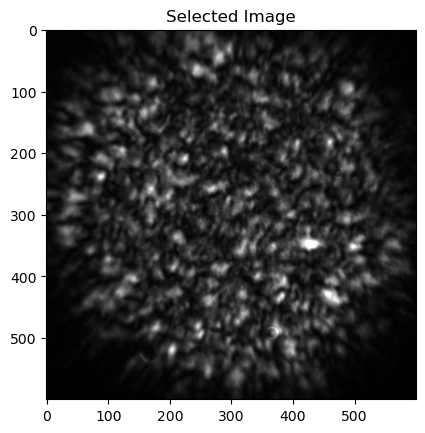

In [40]:
hor_start = 500
ver_start = 300
hor_end = 1100
ver_end = 900

selected = pixelSelection(Im, hor_start, ver_start, hor_end, ver_end)

plt.imshow(selected, cmap='gray')
plt.title('Selected Image')
plt.show()
# plt.colorbar()


In [25]:
Im = selected
inp = Im.ravel()

## 3. Plot

### Probability Distribution

Average Intensity: 25.8081413269043
Input Array: [10. 20. 37. ... 74. 76. 84.]
Max of Normalized Input: 9.841855590553969
Min of Normalized Input: -0.03874746295493689


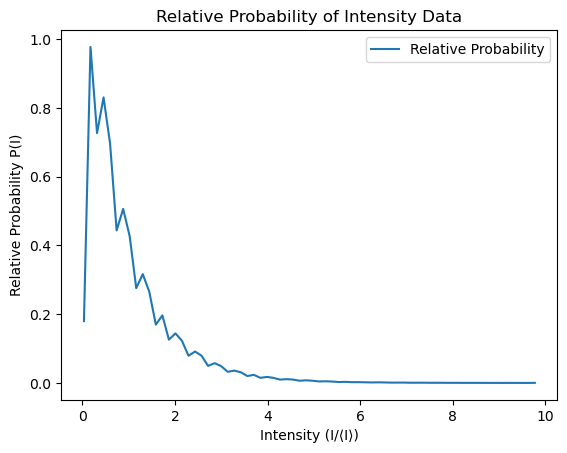

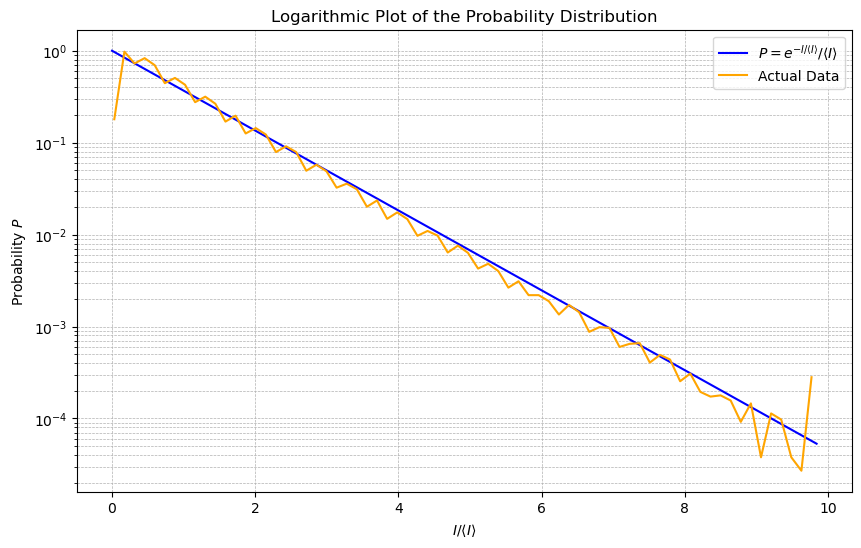

Contrast is 0.9325821474193496
Signal-to-noise ratio is 1.072291596796282
Chi-squared value is 0.8721867247878338 and p-value is 1.0


In [28]:
plotProbabilityDistribution(inp)

# Auto-correlation Function

### Gaussian Beam without a Lens

The intensity distribution $I(\alpha, \beta)$ is taken to be $I(\alpha, \beta)=I_0e^{-2(\frac{\alpha^2}{w_{\alpha}^2}+\frac{\beta^2}{w_{\beta}^2})}$ where $\alpha, \beta$ is the coordinates, and  $w_\alpha, w_\beta$ are the beam waists

The auto correlation function is given by
$$\Gamma_I(\Delta x, \Delta y) = \langle I \rangle^2 \left[ 1 + \left| \frac{\iint_{-\infty}^{\infty} \, I(\alpha, \beta)e^{-i\frac{2\pi}{\lambda z}[\alpha\Delta x+\beta\Delta y]}d\alpha d\beta}{\iint_{-\infty}^{\infty} \, I(\alpha, \beta)d\alpha d\beta} \right|^2 \right]
$$

where $I(\alpha, \beta)$ is the intensity distribution on the scattered surface, which we assume it to be Gaussian , $\lambda$ is the wavelength, and $z$ if the axial distance between the lens and the imaging plane, in this case, the camera, and $\langle I \rangle$ is the average intensity received on the camera

#### Variable

In [86]:
#D = 25.4e-3
L = 650e-9
z = 50e-3
a=2*np.pi/(L*z)
I0 = 200
dx = 5.2e-6
wx= 120
wy= 109
# S_R =
# S_Rx =
# S_Ry =
# print(a)

852009616.0
1114028.9999999767
0.9986924689826505


Text(0, 0.5, '$\\Delta y$')

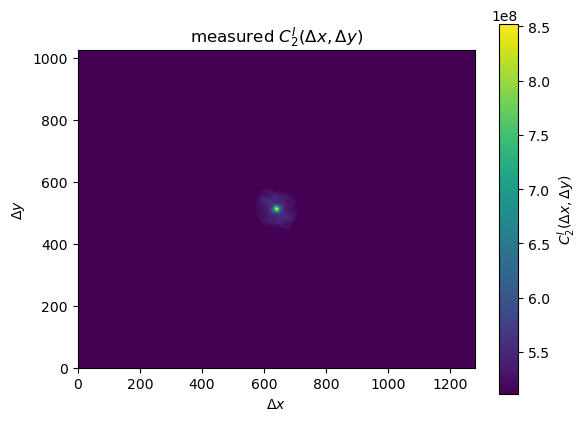

In [89]:
T4 = speckleImgProcessing(Im)

max = np.abs(T4).max()
min = np.abs(T4).min()
print(max)
print(min)
print((max-min)/max)
# print(T2.shape)
plt.imshow(np.abs(T4), cmap='viridis', origin='lower')
plt.clim(np.abs(T4).max()*0.6, np.abs(T4).max())
plt.title(r'measured $C_2^I(\Delta x, \Delta y)$')
plt.colorbar(label=r'$C_2^I(\Delta x, \Delta y)$')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\Delta y$')
# plt.colorbar()

Horizontal FWHM of full wave pattern is 280.0
Vertical FWHM of full wave pattern is 280.0
Horizontal FWHM of cropped wave pattern is 14.0
Vertical FWHM of cropped wave pattern is 14.0


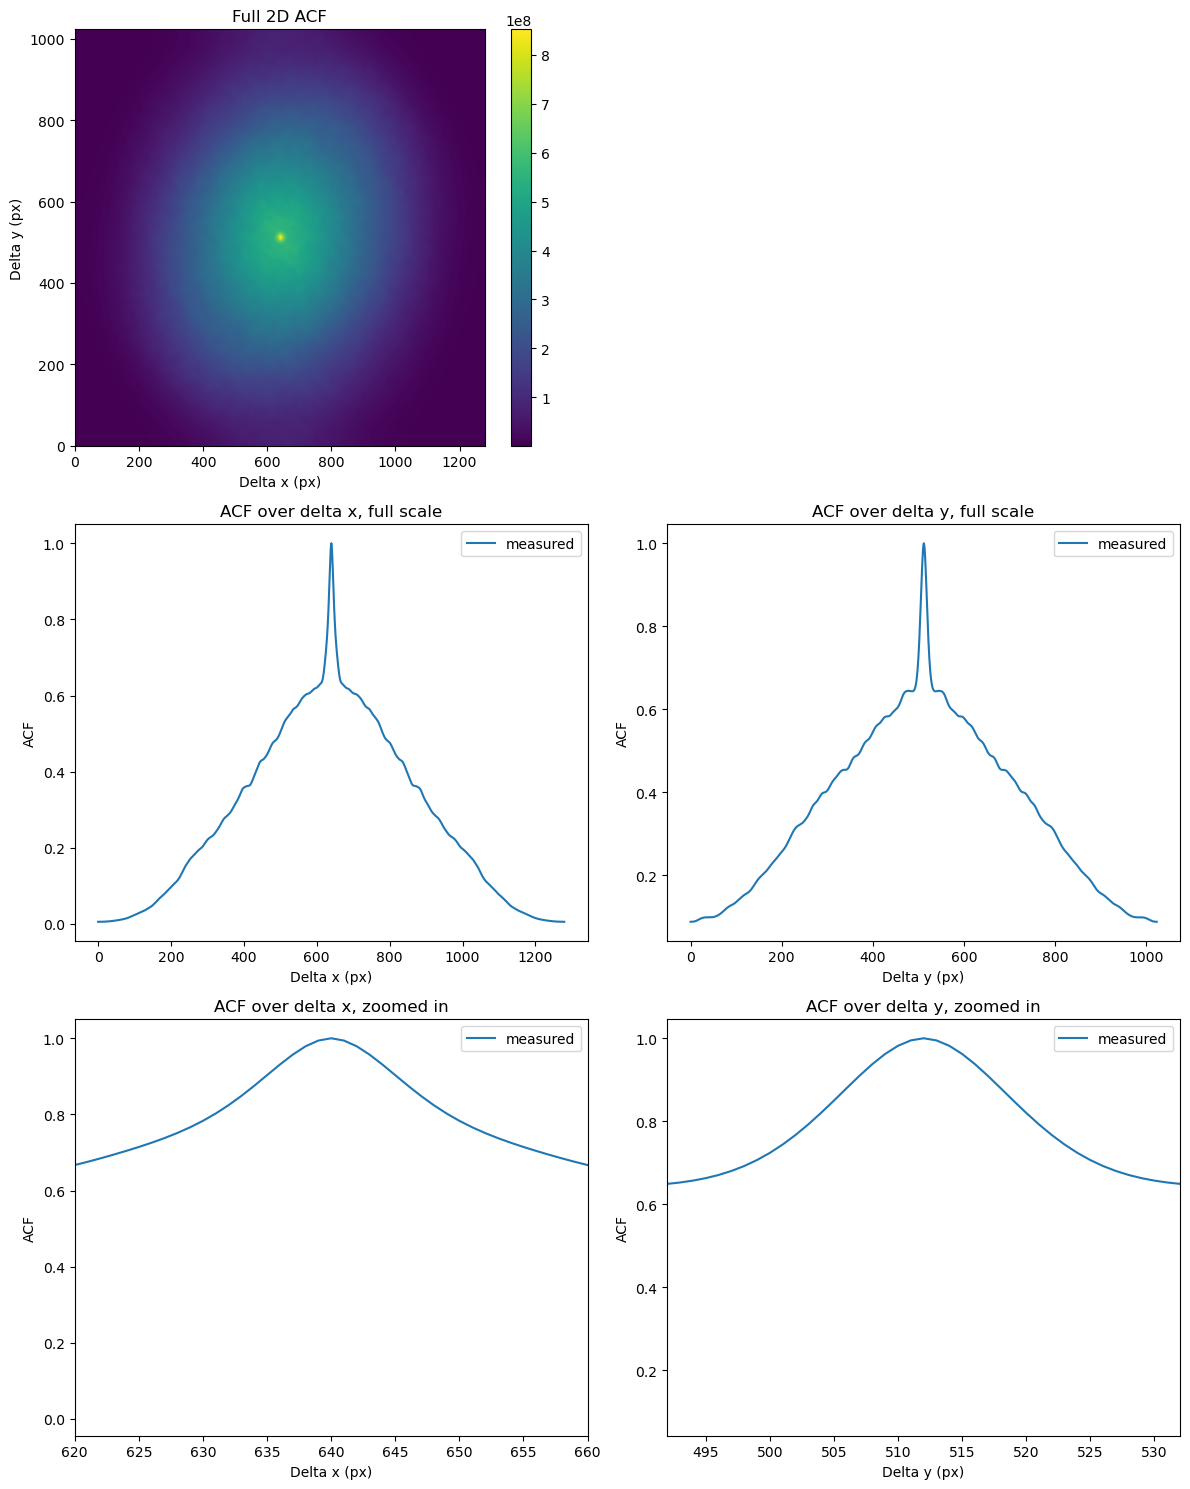

In [91]:
displayMeasuredCorreL(T4)

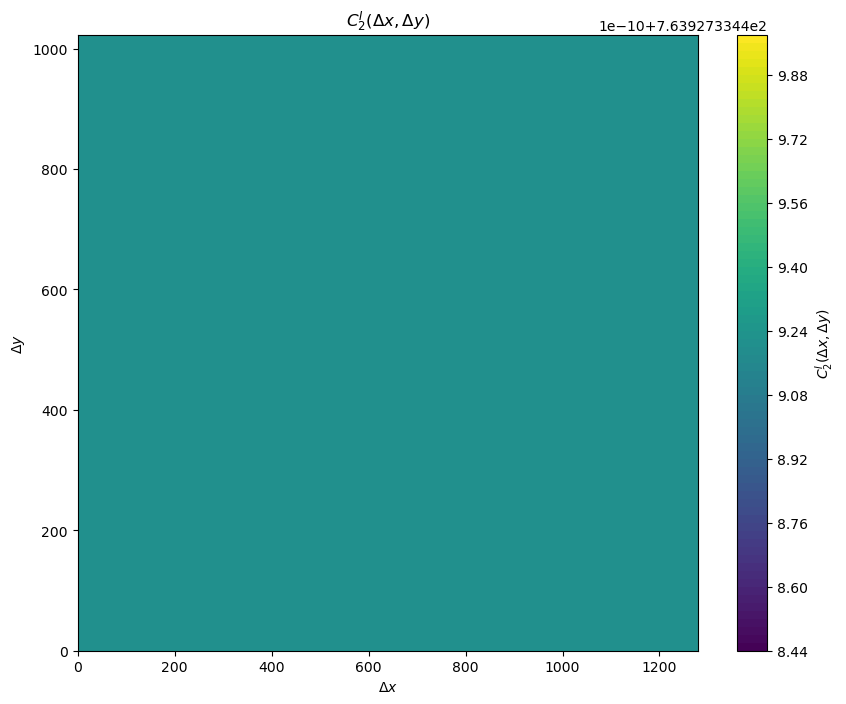

763.9273344179217
763.9273344179209
1.041732411182383e-15


In [115]:
# gr = int(hor/(L*z))
# hr = int(ver/(L*z))
# gr_range = np.linspace(0, gr-1, hor)
# hr_range = np.linspace(0, hr-1, ver)
# alpha_range = np.linspace(0, hor-1, hor*2)
# beta_range = np.linspace(0, ver-1, ver*2)
# g,h = np.meshgrid(gr_range, hr_range)

# # Define the intensity function I(alpha, beta)
# # def I(alpha, beta):
# #     return np.exp(-alpha**2 - beta**2)  # Example: Gaussian intensity

# # Compute the intensity grid
# intensity_grid = I_s(g, h, z)
# # phase = np.exp(-j*2*np.pi*())
# # print(intensity_grid.shape)
# # Compute the 2D FFT of the intensity grid
# plt.contourf(intensity_grid)



# # Shift the zero-frequency component to the center of the spectrum
# fft_intensity = np.fft.fftshift(np.fft.fft2(intensity_grid))


# Compute the normalized result
C2I_values = TheoreticalACF(L, z, wx, wy)
# print(np.sum(intensity_grid))
# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(np.abs(C2I_values), levels=100, cmap='viridis')
plt.colorbar(label=r'$C_2^I(\Delta x, \Delta y)$')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\Delta y$')
plt.title(r'$C_2^I(\Delta x, \Delta y)$')
plt.show()
max = np.abs(C2I_values).max()
min = np.abs(C2I_values).min()
print(max)
print(min)
print((max-min)/max)

Horizontal FWHM of full wave pattern is 0
Vertical FWHM of full wave pattern is 0
Horizontal FWHM of cropped wave pattern is 0
Vertical FWHM of cropped wave pattern is 0


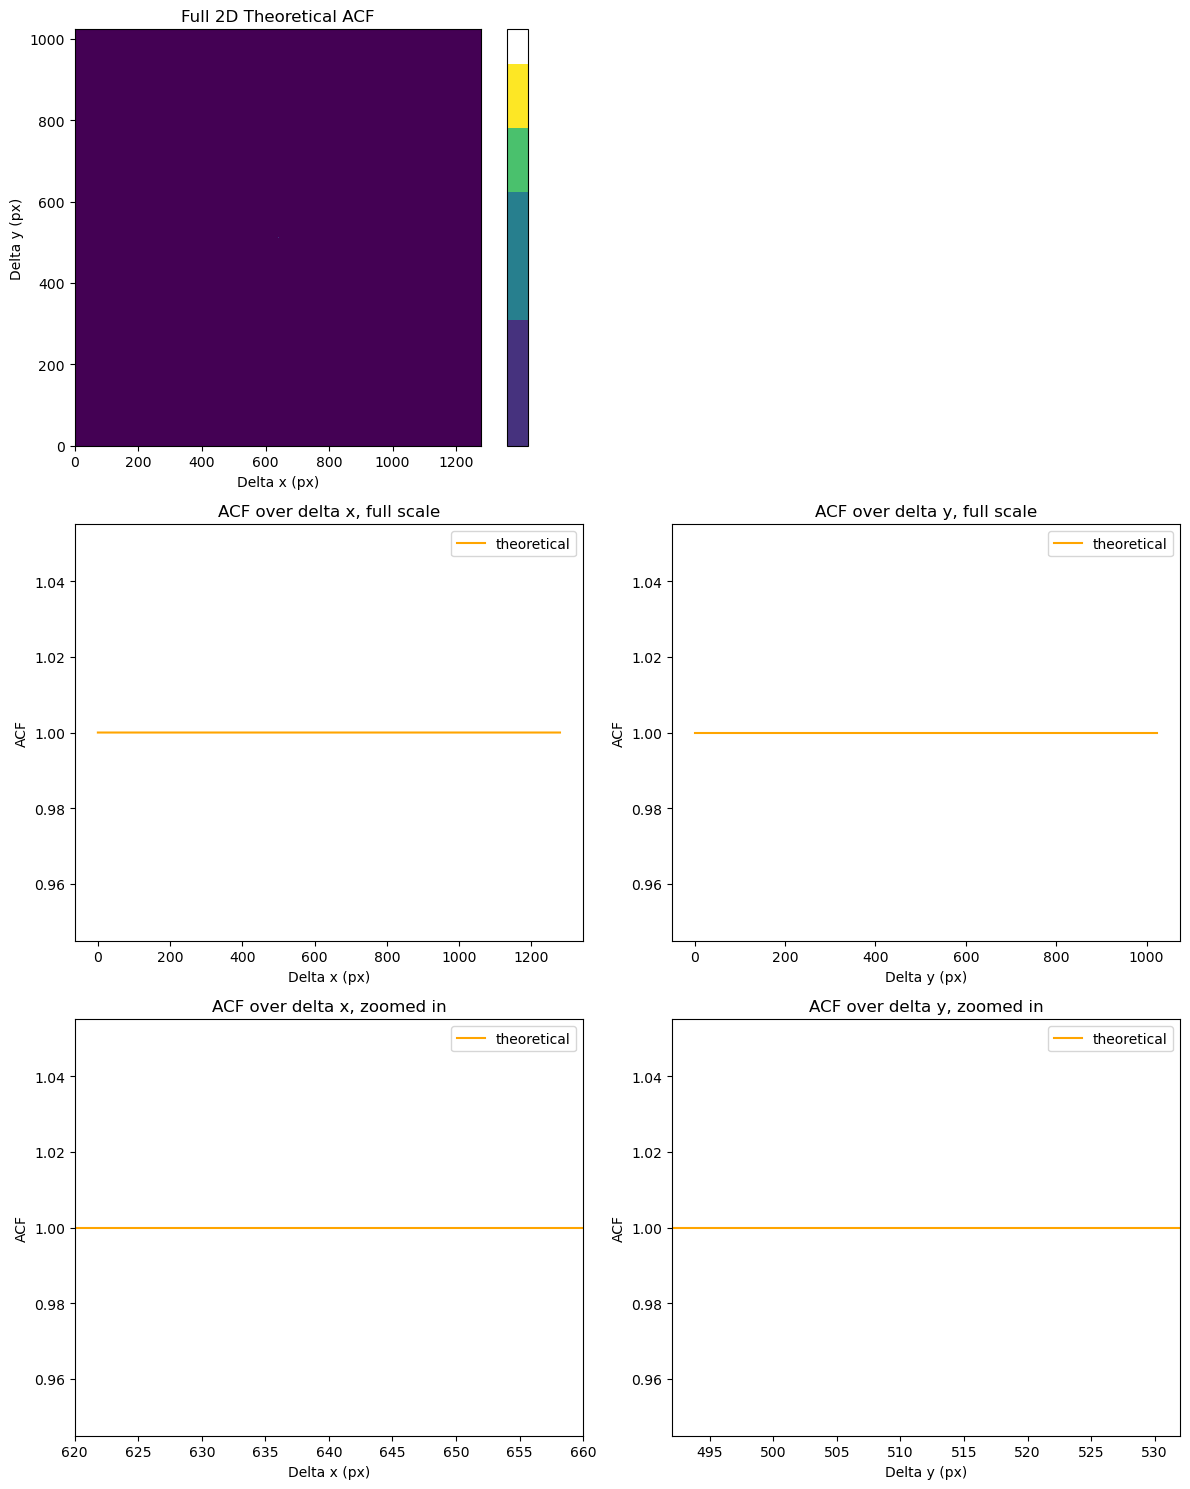

In [116]:
displayTheoreticalCorreL(C2I_values)

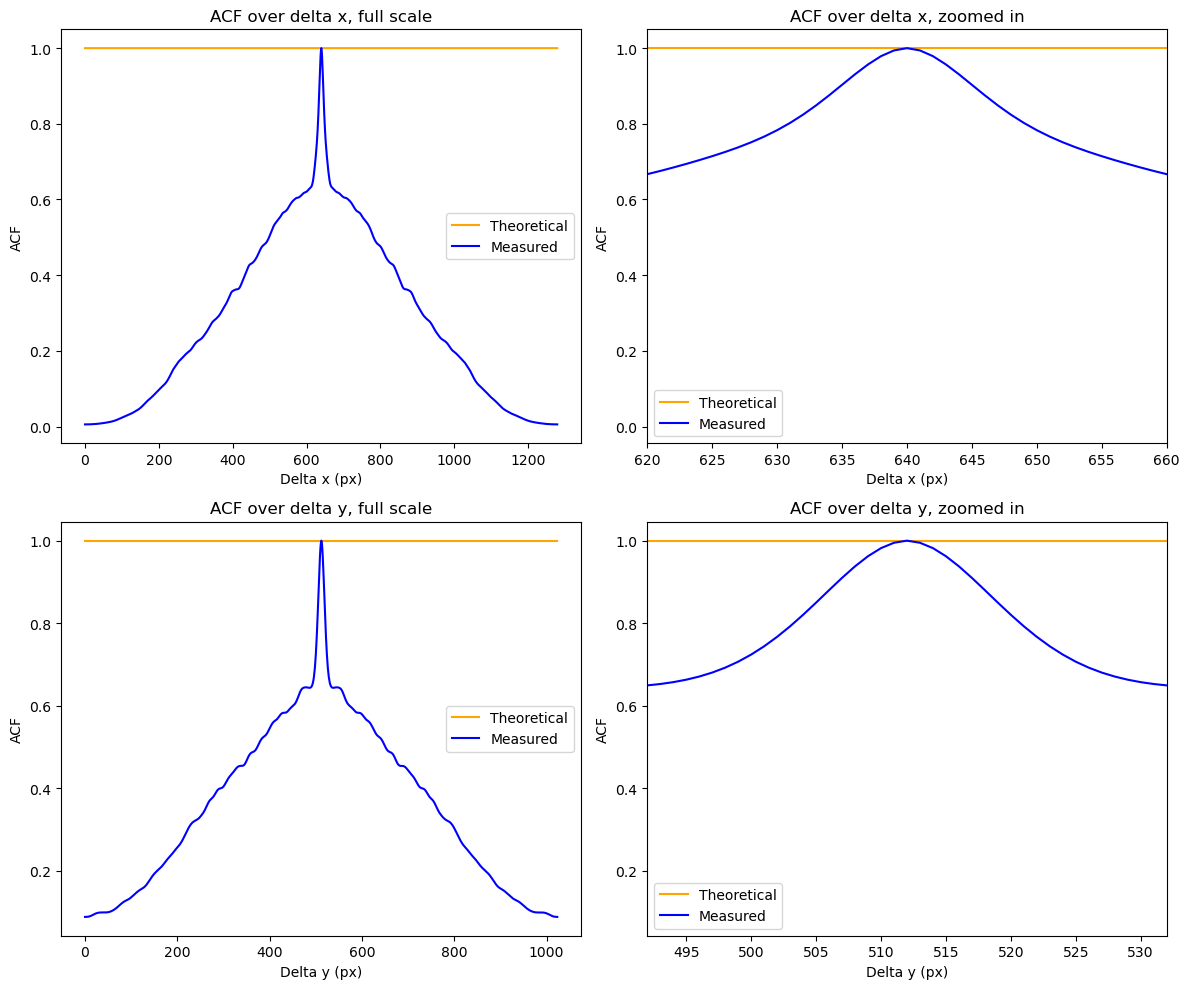

FWHM for theoretical x-axis: 4.0
FWHM for measured x-axis: 14.0


NameError: name 'percentage_error' is not defined

In [97]:
displayComparison(T4, C2I_values)

### Gaussian Beam with a lens

Assume one point to be at the “center”, so $x_1=\Delta x, y_1=\Delta y$  

In [274]:
f = 4e-3

In [24]:
def mu(grr, hrr):
    m1 = int(hor/(L*f))  #2D M for mu 
    n1 = int(ver/(L*f))
    m1_range = np.linspace(0, m1, hor)
    n1_range = np.linspace(0, n1, ver)
    m, n = np.meshgrid(m1_range, n1_range)
    In1 = I_sgh(m, n, f)
    dem = np.fft.fft2(In1)
    num = np.sum(In1)
    return dem/num 
     
    
def I_sgh(g, h, z):
    return I0*np.exp(-2*((((g-(int(ver/(L*z)))/2)*L*z)**2)/wx**2+((((h-(int(hor/(L*z)))/2)*L*z)**2)/wy**2)))
    

In [25]:
def ACF_A(x,y):
    FirstTerm = np.exp(-1j*(np.pi/(L*f)))*((1-z/f)*(x**2+y**2)) # first term
    gr1 = int(hor/(L*f)) #2D M for CiV FT for second term
    hr1 = int(ver/(L*f)) #2D M for CiV FT for second term
    gr1_range = np.linspace(0, gr1, hor) #2D M for CiV FT for second term
    hr1_range = np.linspace(0, hr1, ver) #2D M for CiV FT for second term
    g1,h1 = np.meshgrid(gr1_range, hr1_range) #2D M for CiV FT for second term
    I_gh = I_sgh(g1,h1,f) #2D M for CiV FT for second term
    SecondTerm = np.fft.fft2(I_gh) #second term
    mu_gh = mu(gr1_range, hr1_range) # Calling helpers for component in third term
    ThirdTerm = ((L*f)**2)*np.fft.fft2(mu_gh) # third term
    return FirstTerm*SecondTerm*ThirdTerm
    

[[1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]
 [1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]
 [1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]
 ...
 [1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]
 [1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]
 [1026.38732732 1026.38732732 1026.38732732 ... 1026.38732732
  1026.38732732 1026.38732732]]


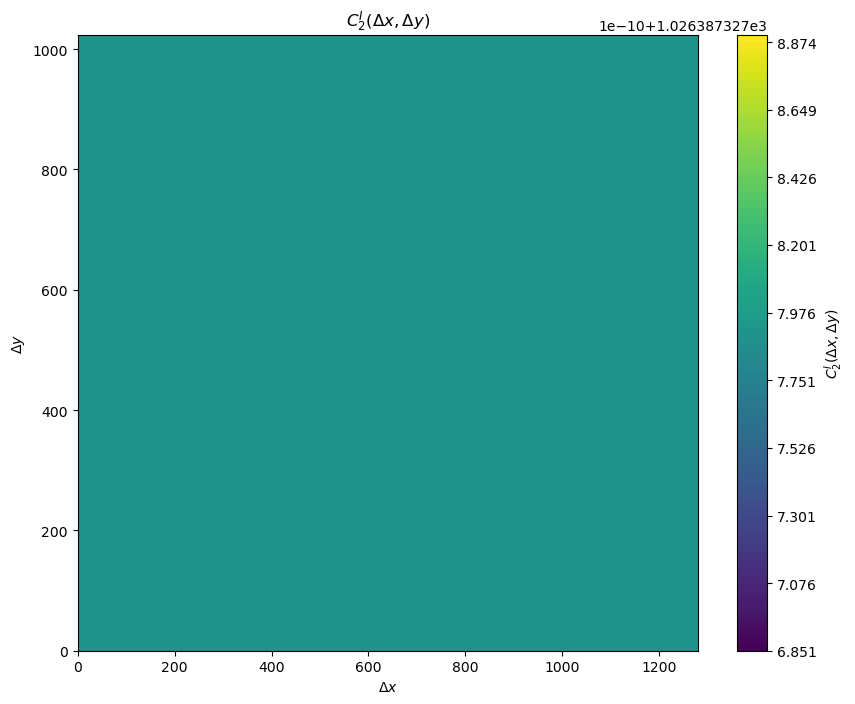

1026.3873273187878
1026.3873273187878


In [26]:
gr0 = int(hor/(L*f))
hr0 = int(ver/(L*f))
gr0_range = np.linspace(0, gr0, hor)
hr0_range = np.linspace(0, hr0, ver)
g0,h0 = np.meshgrid(gr0_range, hr0_range)
I_gh0 = I_sgh(g0,h0,f)
# gr = int(hor/(L*z))
# hr = int(ver/(L*z))
# gr_range = np.linspace(0, gr, hor)
# hr_range = np.linspace(0, hr, ver)
alpha_range = np.linspace(0, hor, hor)
beta_range = np.linspace(0, ver, ver)
x, y= np.meshgrid(alpha_range, beta_range)
inte = I_s(x,y,1/L)
inte0 = I_sgh(x,y,1/L)
mu0 = np.fft.fft2(inte0)/np.sum(inte)
ACF_A00 = (1/(L*f)**2)*np.sum(inte0)*np.sum(mu0)
ACF = (avg**2)*(1+(np.abs(ACF_A(x,y)/ACF_A00))**2)
print(ACF)

# g,h = np.meshgrid(gr_range, hr_range)
plt.figure(figsize=(10, 8))
plt.contourf(alpha_range, beta_range, np.abs(ACF), levels=100, cmap='viridis')
plt.colorbar(label=r'$C_2^I(\Delta x, \Delta y)$')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\Delta y$')
plt.title(r'$C_2^I(\Delta x, \Delta y)$')
plt.show()

max = np.abs(ACF).max()
min = np.abs(ACF).min()
print(max)
print(min)



In [ ]:
lambda_ = 650e-3  # wavelength (example value)
f = 7.5e-3  # focal length (example value)
omega_x = 9.37e-4  # beam waist parameter (example value)
omega_y = 7.2e-4 # beam waist parameter (example value)

# Compute sigma_R,x,y and xi
sigma_R_x = lambda_ * f / (np.pi * omega_x)
sigma_R_y = lambda_ * f / (np.pi * omega_y)
sigma_R = sigma_R_x  # as per the given definition
xi = sigma_R_x / sigma_R_y

# Define the function
def C2I(x, y, I_R, sigma_R, xi):
    return I_R**2 * (1 + np.exp(-(x**2 + xi**2 * y**2) / sigma_R**2))

# Create a grid of x and y values
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)

# Compute the function values
I_R = 1.0  # example intensity value
Z = C2I(X, Y, I_R, sigma_R, xi)

# Plot the function using a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title(r'$C_2^I(\mathbf{r})$')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plot1.png')
plt.show()

# Optionally, you can also create a 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title(r'$C_2^I(\mathbf{r})$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$C_2^I$')
plt.savefig('plot2.png')
plt.show()

In [22]:
r = np.linspace(-10e-1, 10e-1, 100)
C = np.arange(0, 100)
# for i in range(0, 40):
#     C[i] = AT(i)
C = AT(r)
plt.plot(r, C, label='$I(x)$', color='blue')
plt.title('Uniform Circular ACF')
plt.show()

NameError: name 'AT' is not defined

In [ ]:
r_max = 5e-3
r = np.linspace(0, r_max, 1000)
MFD = 6.6e-6
w = MFD/2
L = 650e-9
f = 7.50e-3 
C = avg**2*(1+np.exp(-r**2/(L*f/(np.pi*w))**2))
plt.plot(r, C, label='$P = e^{-I/\\langle I \\rangle}/\\langle I \\rangle$', color='blue')

# Actual data plot (using histogram)
#plt.plot(bin_centers, hist, label='Actual Data', color='orange')

# Set the y-axis to a logarithmic scale
#plt.yscale('log')

# Labels and title
plt.xlabel('$I/\\langle I \\rangle$')
plt.ylabel('Probability $P$')
plt.title('Gaussian ACF')

# Legend and grid
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show and save the plot
#plt.savefig('resultsD.png')
plt.show()
